In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from numpy import linalg as LA
import time

In [11]:
import chardet
with open('Project2-data/movie_titles.txt','rb') as ipt:
    result=chardet.detect(ipt.read())
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [13]:
with open('Project2-data/movie_titles.txt','r',encoding='latin_1') as ipt:
    ipt.readlines()

In [22]:
users = pd.read_csv('Project2-data/users.txt',header=None, names=['user_id'])
movies = pd.read_csv('Project2-data/movie_titles.txt',header=None, names=['movie_id','year','name'],sep=',',dtype={'name':'object'},encoding='latin_1')
train = pd.read_csv('Project2-data/netflix_train.txt',header=None, names=['user_id','movie_id','grade','time'],sep=' ')
test = pd.read_csv('Project2-data/netflix_test.txt',header=None, names=['user_id','movie_id','grade','time'],sep=' ')

In [63]:
len([i for i,_ in test.groupby('user_id')])

10000

In [64]:
users.shape

(10000, 1)

In [24]:
users.to_hdf('users.h5',key='users')
movies.to_hdf('movies.h5',key='movies')

In [25]:
# 填充数组
gradeMatrix = np.zeros((users.shape[0],movies.shape[0]))
userMatrix = np.zeros(users.shape[0],dtype=int)
for i,(user_id, info) in enumerate(train.groupby('user_id')):
    userMatrix[i] = user_id
    gradeMatrix[i,movieMap(np.array(info['movie_id']))] = np.array(info['grade'])

In [26]:
# 警告，此处默认test里用户也是10000个，纯粹是手动查看的结果
gradeTest = np.zeros((users.shape[0],movies.shape[0]))
userTest = np.zeros(users.shape[0],dtype=int)
for i,(user_id, info) in enumerate(test.groupby('user_id')):
    userTest[i] = user_id
    gradeTest[i,movieMap(np.array(info['movie_id']))] = np.array(info['grade'])

In [24]:
def movieMap(i):
    return i-1

In [27]:
with h5py.File('train.h5','w') as opt:
    opt.create_dataset('users',data=userMatrix,compression='gzip')
    opt.create_dataset('grades',data=gradeMatrix,compression='gzip')
with h5py.File('test.h5','w') as opt:
    opt.create_dataset('users',data=userTest,compression='gzip')
    opt.create_dataset('grades',data=gradeTest,compression='gzip')    

In [2]:
with h5py.File('train.h5','r') as opt:
    #userMatrix = opt['users'][:]
    gradeMatrix = opt['grades'][:]
with h5py.File('test.h5','r') as opt:
    #userTest = opt['users'][:]
    gradeTest = opt['grades'][:]

In [152]:
gradeMatrix[0,120:130]

array([0., 0., 0., 0., 0., 3., 0., 0., 0., 0.])

In [3]:
np.where((userTest-userMatrix)!=0)

(array([], dtype=int64),)

In [151]:
gradeTest[0,120:130]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [144]:
np.where(userMatrix==305344)

(array([1074], dtype=int64),)

In [30]:

userTrainSparse = sparse.lil_matrix(userMatrix)
gradeTrainSparse = sparse.lil_matrix(gradeMatrix)
userTestSparse = sparse.lil_matrix(userTest)
gradeTestSparse = sparse.lil_matrix(gradeTest)

In [4]:
del userMatrix, userTest

In [82]:
gradeTestSparse.shape

(10000, 17770)

In [32]:
def similarity(grade):
    # normalGrade = grade.dot()
    return grade.dot(grade.transpose())

In [33]:
simDR = similarity(gradeTrainSparse)

In [35]:
# 除以向量长度
divider = sparse.lil_matrix(np.diag(1/np.sqrt(simDR.diagonal())))

In [36]:
simDR = divider.dot(simDR.dot(divider))

In [40]:
with h5py.File('similarity.h5','w') as opt:
    opt.create_dataset('similar', data=simDR.todense(),compression='gzip')

In [41]:
del simDR

In [18]:
with h5py.File('similarity.h5','r') as ipt:
    simDR = ipt['similar'][:]

In [43]:
simDRmerge = np.zeros(10000*10001//2)
def maptril(i,j):
    if i<j:
        i,j=j,i
    return int(i*(i+1)//2)+j
for i in range(10000):
    simDRmerge[maptril(i,0):maptril(i,i)] = simDR[i,0:i]
with h5py.File('similarityMerge.h5','w') as opt:
    opt.create_dataset('similar', data=simDRmerge,compression='gzip')

In [54]:
# 选择0.45和100作为条件，筛选出类似人选
np.where(simDR[0,:]>0.45)[0].shape

(2,)

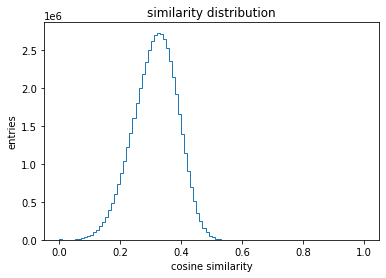

In [53]:
#寻找前k个最相似的，先看距离分布
fig, ax = plt.subplots()
ax.hist(simDRmerge,bins=100,range=[0,1],histtype='step')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('entries')
ax.set_title('similarity distribution')
plt.savefig('similarityDistribution.png')

In [37]:
def filter(simDR,threshold=0.45, minNum=50,minStep=0.05):
    simFilter = [[]]*simDR.shape[0]
    print(len(simFilter))
    for i in range(simDR.shape[0]):
        #排除自身
        simFilter[i] = np.where((simDR[i,:]>threshold)&(simDR[i,:]<1))[0]
        while len(simFilter[i])<minNum:
            threshold = threshold-minStep
            simFilter[i] = np.where((simDR[i,:]>threshold)&(simDR[i,:]<1))[0]
    return simFilter
simFilter = filter(simDR,0.35,5000)

10000


In [1]:
len(simFilter[0])

NameError: name 'simFilter' is not defined

In [38]:
import time
simDRMask = np.zeros(simDR.shape)
for i in range(len(simFilter)):
    simDRMask[i,simFilter[i]] = simDR[i,simFilter[i]]

In [12]:
np.where(simDRMask[0]!=0)

(array([  10,   17,   31, ..., 9970, 9986, 9989], dtype=int64),)

In [6]:
gradeMask = np.zeros(gradeMatrix.shape)
gradeMask[gradeMatrix!=0] = 1

In [37]:
maskTest = np.zeros(gradeTest.shape)
maskTest[gradeTest!=0] = 1

In [39]:
simWeight = simDRMask.dot(gradeMask)


In [40]:
np.where(simWeight!=0)[0].shape

(99999975,)

In [41]:
simWeight[simWeight==0] = 1

In [42]:
start = time.time()
predict = simDRMask.dot(gradeMatrix)/simWeight
print('use time {:.2f}'.format(time.time()-start))

use time 84.18


In [ ]:
with h5py.File('predict.h5','w') as opt:
    opt.create_dataset('predict', data=predict, compression='gzip')

In [8]:
from numpy import linalg as LA
def rmse(predict, truth):
    predict[truth==0] = 0
    num = np.count_nonzero(truth)
    return LA.norm(predict-truth)/np.sqrt(num)


In [118]:
rmse(predict,gradeTest)

array([0.        , 0.        , 0.20374798, ..., 0.        , 0.        ,
       0.        ])

In [119]:
gradeTest[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [18]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          _i18:  588.0 B
                    local_vars:  520.0 B
                           _oh:  360.0 B
                           Out:  360.0 B
                           _i8:  268.0 B
                           _ih:  264.0 B
                            In:  264.0 B
                           _i2:  257.0 B
                            _i:  159.0 B
                          _i17:  159.0 B


In [29]:
def similarityNorm(grade):
    # normalGrade = grade.dot()
    gradeNorm = (gradeMatrix-np.mean(gradeMatrix,axis=1).reshape(-1,1))/np.std(gradeMatrix,axis=1).reshape(-1,1)
    sim = gradeNorm.dot(gradeNorm.T)
    divider = np.diag(1/np.sqrt(sim.diagonal()))
    return divider.dot(sim.dot(divider))
simDRNorm = similarityNorm(gradeMatrix)

In [30]:
simDRNorm[0]

array([1.        , 0.26133439, 0.25018734, ..., 0.23341023, 0.31067012,
       0.29340141])

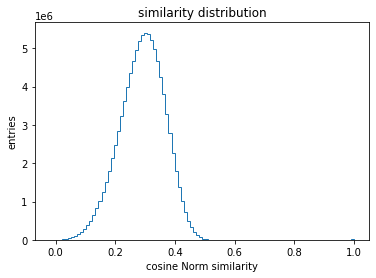

In [31]:
fig, ax = plt.subplots()
ax.hist(simDRNorm.reshape(-1,),bins=100,histtype='step')
ax.set_xlabel('cosine Norm similarity')
ax.set_ylabel('entries')
ax.set_title('similarity distribution')
plt.savefig('similarityNormDistribution.png')

In [33]:
def filterPredict(simDR,mean,sigma):
    simFilter = filter(simDR,0.35,1000)
    simDRMask = np.zeros(simDR.shape)
    gradeNorm = (gradeMatrix-np.mean(gradeMatrix,axis=1).reshape(-1,1))/np.std(gradeMatrix,axis=1).reshape(-1,1)
    for i in range(len(simFilter)):
        simDRMask[i,simFilter[i]] = simDR[i,simFilter[i]]
    print('begin predict')
    start = time.time()
    predict = simDRMask.dot(gradeNorm)/np.sum(simDRMask,axis=1).reshape(-1,1)*sigma.reshape(-1,1)+mean.reshape(-1,1)
    print('use time {:.2f}'.format(time.time()-start))
    print('rmse {:.2f}'.format(rmse(predict,gradeTest)))
filterPredict(simDRNorm,np.mean(gradeMatrix,axis=1),np.std(gradeMatrix,axis=1))

10000
begin predict
use time 346.11
rmse 2.53


In [34]:
rmse(np.ones(gradeTest.shape)*3,gradeTest)

1.1715111196739934

In [13]:
a=np.array([4,0,0,5,1,0,0])
b=np.array([5,5,4,0,0,0,0])
c=np.array([0,0,0,2,4,5,0])


In [14]:
a.dot(b.T)

20

In [15]:
a

array([4, 0, 0, 5, 1, 0, 0])

In [16]:
def simi(a,b):
    return a.dot(b.T)/np.sqrt(np.sum(a**2)*np.sum(b**2))
simi(gradeMatrix[200],gradeMatrix[1000])

0.2527042240634319

In [17]:
print(simDR[200,1000])

0.25270422406343185


## 矩阵分解

In [ ]:
def grad(X,A, U,V,lamb):
    coeff = A*(U.dot(V.T)-X)
    partialU = coeff.dot(V)+2*lamb*U
    partialV = (coeff.T).dot(U)+2*lamb*V
    return partialU, partialV,0.5*np.sum(coeff**2)+np.sum(U**2)+np.sum(V**2)

def train(trainData,mask,k=50,lamb=0.01,alpha=1e-4):
    U = np.ones((trainData.shape[0],k))*1/k
    V = np.ones((trainData.shape[1],k))*3/k
    J = []
    Jtemp0 = 0
    lossValue = []
    delta = 1
    times = 0
    lossValue.append(rmse(U.dot(V.T),gradeTest))
    while delta>1e-1 and times<50:
        coeff = mask*(U.dot(V.T)-trainData)
        partialU = coeff.dot(V)+2*lamb*U
        partialV = (coeff.T).dot(U)+2*lamb*V
        Jtemp = 0.5*np.sum(coeff**2)+np.sum(U**2)+np.sum(V**2)
        #partialU,partialV,Jtemp = grad(trainData,mask,U,V,lamb)
        print('time{},{:.2f},{:.2f}'.format(times,partialU[0,0],Jtemp))
        J.append(Jtemp)
        Utemp = U-alpha*partialU
        Vtemp = V-alpha*partialV
        delta = np.abs(Jtemp-Jtemp0)
        Jtemp0 = Jtemp
        U = Utemp
        V = Vtemp
        lossValue.append(rmse(U.dot(V.T),gradeTest))
        times += 1
    J.append(0.5*np.sum(((U.dot(V.T)-trainData)*mask)**2)+np.sum(U**2)+np.sum(V**2))
    print('delta:{},times:{}'.format(delta, times))
    return U, V, J,lossValue

In [19]:
start=time.time()
U,V,J,lossValue=train(gradeMatrix,gradeMask)
print('use time {:.2f}'.format(time.time()-start))

time0,-91.75,42371100.34
time1,-125.88,40412073.86
time2,-176.59,36387575.04
time3,-228.20,29022317.78
time4,-239.86,19149037.90
time5,-181.23,11879598.61
time6,-119.42,8851823.78
time7,-90.90,7258985.77
time8,-68.93,6276221.97
time9,-54.09,5622805.29
time10,-43.63,5162873.39
time11,-36.17,4824597.25
time12,-30.66,4566975.10
time13,-26.47,4365115.29
time14,-23.21,4203162.15
time15,-20.61,4070610.66
time16,-18.50,3960267.80
time17,-16.75,3867066.80
time18,-15.29,3787349.69
time19,-14.03,3718417.73
time20,-12.96,3658241.17
time21,-12.02,3605266.92
time22,-11.19,3558287.95
time23,-10.46,3516352.86
time24,-9.81,3478702.06
time25,-9.23,3444721.85
time26,-8.70,3413911.05
time27,-8.23,3385856.27
time28,-7.80,3360213.35
time29,-7.41,3336693.43
time30,-7.05,3315052.09
time31,-6.72,3295081.09
time32,-6.42,3276601.82
time33,-6.15,3259460.19
time34,-5.89,3243522.48
time35,-5.65,3228672.09
time36,-5.43,3214806.86
time37,-5.23,3201836.86
time38,-5.04,3189682.66
time39,-4.86,3178273.78
time40,-4.69,3

KeyboardInterrupt: 

In [91]:
fig,ax=plt.subplots()
ax.plot(lossValue,label='loss')
ax2=ax.twinx()
ax2.plot(J,label='J')
ax.legend()
ax.set_xlabel('iteration time')
# plt.savefig('iteration.png')

array([0., 0., 0., 0., 0., 3., 0., 0., 0., 0.])

In [92]:
for k in [10,50,100]:
    for j in [1,0.1, 0.01,0.001]:
        U,V,J,lossValue=train(gradeMatrix,gradeMask)
        print('k,j:{},{};rmse:{:.2f}'.format(k,j,lossValue[-1]))

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

array([   -0.        ,     0.        ,     0.        ,     0.        ,
           0.        , 11175.62516802,     0.        ,     0.        ,
           0.        ,    -0.        ])

In [97]:
U.dot(V.T)[0,120:130]

array([ -372.23774298, 35196.42832002,  1368.69091902,   794.69715402,
       39893.14623402, 11175.62516802, 48120.76171602,  4272.09627402,
        7899.95977902,  -261.89719398])

In [21]:
import torch
import math

In [22]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [33]:
trainData= torch.from_numpy(gradeMatrix).cuda()
testData = torch.from_numpy(gradeTest).cuda()

In [34]:
maskData = torch.from_numpy(gradeMask).cuda()

In [ ]:
maskTest = torch.from_numpy(gradeTest).cuda()

In [25]:
k=50
U = torch.randn((gradeMatrix.shape[0],k),device=device,requires_grad=True)
V = torch.randn((gradeMatrix.shape[1],k),device=device,requires_grad=True)

In [51]:
class poly(torch.nn.Module):
    def __init__(self,k=50):
        super().__init__()
        self.U = torch.nn.Parameter(torch.randn((gradeMatrix.shape[0],k),device=device,requires_grad=True))
        self.V = torch.nn.Parameter(torch.randn((gradeMatrix.shape[1],k),device=device,requires_grad=True))
    def forward(self,y):
        #torch.matmul(U,torch.transpose(V))
        return 0.5*torch.norm(torch.mul(maskData,y-torch.matmul(self.U,self.V.transpose(0,1))))**2+lamb*(torch.norm(self.U)**2+torch.norm(self.V)**2)
    def rmse(self,y):
        return torch.norm(torch.mul(maskTest,y-torch.matmul(self.U,self.V.transpose(0,1))))

In [ ]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return 0.5*torch.norm(torch.mul(maskData,y-x))**2+lamb*(torch.norm(U)**2+torch.norm(V)**2)
    

In [49]:
learning_rate = 1e-3
lamb=0.01
model = poly()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for t in range(5000):
    loss= model(trainData)
    if t%100 ==0:
        print(t,loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 216161771.04737476
100 168513600.29834396
200 136126463.34589657
300 111804000.47308272
400 88367039.8815375
500 64856540.147545524
600 48311188.31396722
700 37961713.296979874
800 30807699.607565857
900 25466605.827187438
1000 21316480.11159924
1100 18013509.223536022
1200 15339825.101951873
1300 13147557.02499262
1400 11332600.48053418
1500 9819849.587626299
1600 8553903.181041826
1700 7492861.365028502
1800 6604098.639670124
1900 5861395.607031589
2000 5243028.19871899
2100 4730523.9417551365
2200 4307874.016240554
2300 3961043.3889205228
2400 3677665.4861143907
2500 3446841.9348259238
2600 3258997.6341164117
2700 3105769.361826546
2800 2979928.0076151374
2900 2875350.3171419636
3000 2787053.015787406
3100 2711267.318733903
3200 2645466.1273034415
3300 2588215.4148807977
3400 2538793.297947314
3500 2496696.7431069664
3600 2461263.0860998086
3700 2431542.400488162
3800 2406375.753599012
3900 2384547.9769915594
4000 2364918.680809875
4100 2346505.0854815026
4200 2328529.477612723
43

In [50]:
rmse(model.U.cpu().detach().numpy().dot(model.V.cpu().detach().numpy().T),gradeTest)

0.9027223843087977

In [47]:
model.U.cpu().detach().numpy()

array([[-0.27325168, -0.5808143 , -0.95366865, ..., -0.9256683 ,
         0.36562392,  0.3893332 ],
       [-0.36387172, -1.348269  , -0.07453873, ..., -0.19496754,
         0.43181995,  1.977597  ],
       [ 0.9629586 ,  0.01253332,  0.1200662 , ...,  0.49402824,
        -1.0437483 , -1.6892343 ],
       ...,
       [-0.50993484,  1.2763777 ,  0.06429432, ..., -0.46602723,
         0.82997924,  1.229044  ],
       [ 2.6294131 , -1.2693384 , -0.426589  , ...,  1.0714242 ,
        -0.92700875,  0.36979368],
       [ 0.36741003, -0.52827173, -0.51916987, ...,  1.2765571 ,
         0.3302791 ,  0.77558845]], dtype=float32)

In [53]:
for k in [50]:
    for j in [1,0.1, 0.01,0.001]:
        learning_rate = 1e-3
        lamb=j
        model = poly(k)
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        for t in range(5000):
            loss= model(trainData)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('k,j:{},{};rmse:{:.2f}'.format(k,j,rmse(model.U.cpu().detach().numpy().dot(model.V.cpu().detach().numpy().T),gradeTest)))

k,j:50,1;rmse:0.87
k,j:50,0.1;rmse:0.89
k,j:50,0.01;rmse:0.90
k,j:50,0.001;rmse:0.91
